In [109]:
import itertools
import pandas as pd
import pandas_profiling
import numpy as np
import scipy.stats
import re
import math
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.backends.backend_agg
import matplotlib.figure
import seaborn as sns
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score

In [110]:
vehicles_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/AlejandroPenaloza/cars-value-predictor/master/cars-features-dataset.csv')
vehicles_dataset.drop(columns='Unnamed: 0', inplace=True)
print(vehicles_dataset.shape)
vehicles_dataset.head()

(16920, 18)


,Make,Model,Year,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
0,Ford,Focus,2014.0,"35,795",Automatic,2.0L Inline-4 Gas,NaN,Charcoal Black,26 cty / 36 hwy,Gas,FWD,Tacoma,WA,SE Hatchback,2 reported accidents,Standard,NaN,"7,999"
1,Ford,F-150,2015.0,"128,146",Automatic,2.7L V-6 Gas Turbocharged,Unknown,Medium Earth Gray,19 cty / 26 hwy,Gas,RWD,Waxahachie,TX,XL SuperCrew 6.5\' Box RWD,0 reported accidents,NaN,Standard Bed,"15,991"
2,Mercedes-Benz,E-Class,2004.0,"135,000",Automatic,5.0L V-8 Gas,Black,Beige,16 cty / 22 hwy,Gas,AWD,Covina,CA,E 500 4MATIC Wagon,0 reported accidents,Standard,NaN,"5,950"
3,Hyundai,Elantra,2011.0,"135,670",Automatic,1.8L Inline-4 Gas,NaN,Gray,28 cty / 38 hwy,Gas,FWD,Miami,FL,NaN,0 reported accidents,Standard,NaN,"3,999"
4,Toyota,Prius,2012.0,"152,543",Automatic,1.8L Inline-4 Hybrid,White,Biege,51 cty / 48 hwy,Hybrid,FWD,Byhalia,MS,Five,1 reported accidents,Standard,NaN,"6,500"


## Exploratory Data Analysis

In [ ]:
pandas_profiling.ProfileReport(vehicles_dataset)

In [111]:
vehicles_dataset['Year'] = vehicles_dataset['Year'].astype('object')

In [112]:
vehicles_dataset.describe()

,Make,Model,Year,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
count,16024,15997,16098.0,16571,16534,13375,11080,15635,16553,16584,16636,16207,16172,15173,16139,14679,1279,16004
unique,121,615,24.0,6442,2,122,577,325,274,7,5,1311,52,1327,5,4,3,3217
top,Ford,Sentra,2019.0,"29,842",Automatic,2.5L Inline-4 Gas,Black,Black,29 cty / 37 hwy,Gas,FWD,Phoenix,TX,SE FWD,0 reported accidents,Standard,Short Bed,"9,995"
freq,2158,563,4272.0,20,16036,2045,821,4577,638,15625,9719,235,1997,444,13441,9801,603,119


In [113]:
vehicles_dataset.dtypes

Make                     object
Model                    object
Year                     object
Mileage                  object
Transmission             object
Engine                   object
Exterior Color           object
Interior Color           object
MPG                      object
Fuel Type                object
Drive Type               object
Location (City)          object
Location (State)         object
Style                    object
Condition (Accidents)    object
Options Level            object
Bed Length               object
Price                    object
dtype: object

In [114]:
vehicles_dataset.isnull().sum(axis=0)

Make                       896
Model                      923
Year                       822
Mileage                    349
Transmission               386
Engine                    3545
Exterior Color            5840
Interior Color            1285
MPG                        367
Fuel Type                  336
Drive Type                 284
Location (City)            713
Location (State)           748
Style                     1747
Condition (Accidents)      781
Options Level             2241
Bed Length               15641
Price                      916
dtype: int64

In [115]:
columns_by_nulls = vehicles_dataset.isnull().sum().sort_values(ascending=True)
print(columns_by_nulls)
#the following is an array with columns sorted by nulls amount within them.
sorted_columns = columns_by_nulls.index.to_numpy()
sorted_columns

Drive Type                 284
Fuel Type                  336
Mileage                    349
MPG                        367
Transmission               386
Location (City)            713
Location (State)           748
Condition (Accidents)      781
Year                       822
Make                       896
Price                      916
Model                      923
Interior Color            1285
Style                     1747
Options Level             2241
Engine                    3545
Exterior Color            5840
Bed Length               15641
dtype: int64


array(['Drive Type', 'Fuel Type', 'Mileage', 'MPG', 'Transmission',
       'Location (City)', 'Location (State)', 'Condition (Accidents)',
       'Year', 'Make', 'Price', 'Model', 'Interior Color', 'Style',
       'Options Level', 'Engine', 'Exterior Color', 'Bed Length'],
      dtype=object)

This high quantity of allegedly null values is due to lack of information when inputting specifications in each car listing from its owner or merchant.
Some of them will be dropped but most of them will be labeled as another data category.

In [116]:
vehicles_dataset.dropna(subset=['Make', 'Model'], inplace=True)
sorted_columns = np.setdiff1d(sorted_columns, np.array(['Make', 'Model']), assume_unique=True)
vehicles_dataset.shape

(15983, 18)

Make and model are too important to have as an specific information for each row, so the ones were Make and Model are missing were dropped.

In [117]:
print(sorted_columns[0])
sorted_columns = sorted_columns[1:]

Drive Type


Now, 'Drive Type' will be analyzed.

In [118]:
vehicles_dataset['Drive Type'].value_counts()

FWD        9347
AWD        2648
4WD        2144
RWD        1813
Unknown       8
Name: Drive Type, dtype: int64

In [119]:
vehicles_dataset['Drive Type'].isnull().sum()

23

This variable has just 23 null values. In addition to that there is one category called 'Unknown', which has only 8 occurrences.
The rows presenting these values are going to be eliminated.

In [120]:
vehicles_dataset["Drive Type"] = vehicles_dataset["Drive Type"].apply(
    lambda dt: (dt, np.NaN)[dt == 'Unknown'])
vehicles_dataset.dropna(subset=["Drive Type"], inplace=True)

In [121]:
vehicles_dataset.shape

(15952, 18)

In [122]:
print(sorted_columns[0])
sorted_columns = sorted_columns[1:]

Fuel Type


The next variable with the least amount of null values is 'Fuel Type'.

In [123]:
print(vehicles_dataset['Fuel Type'].value_counts())
vehicles_dataset['Fuel Type'].isnull().sum()

Gas         14999
Hybrid        482
Diesel        266
Plug-In        99
Electric       64
Hydrogen        3
CNG             2
Name: Fuel Type, dtype: int64


37

'CNG' and 'Hydrogen will be dismissed, they have but 5 presences. 

In [124]:
vehicles_dataset['Fuel Type'] = vehicles_dataset['Fuel Type'].apply(
    lambda ft: (ft, np.NaN)[ft in ['Hydrogen', 'CNG']])
vehicles_dataset.dropna(subset=['Fuel Type'], inplace=True)

In [125]:
vehicles_dataset.shape

(15910, 18)

In [126]:
print(sorted_columns[0])
sorted_columns = sorted_columns[1:]

Mileage


'Mileage' column comes on.

In [127]:
print(vehicles_dataset['Mileage'].value_counts())
vehicles_dataset['Mileage'].isnull().sum()

29,842     20
148,040    19
152,997    18
51,821     16
92,897     15
           ..
138,784     1
35,468      1
49,206      1
49,648      1
63,503      1
Name: Mileage, Length: 6271, dtype: int64


12

In [98]:
#sorted(list(map(lambda m: str(m), vehicles_dataset['Mileage'].unique())), reverse=True)

In [128]:
vehicles_dataset.dropna(subset=['Mileage'], inplace=True)

In [130]:
vehicles_dataset['Mileage'] = vehicles_dataset['Mileage'].apply(lambda m: m.replace(',', ''))
vehicles_dataset['Mileage'] = vehicles_dataset['Mileage'].astype('int64')
vehicles_dataset['Mileage'].value_counts()

In [145]:
scipy.stats.describe(vehicles_dataset['Mileage'])

DescribeResult(nobs=15898, minmax=(5, 428197), mean=58815.70228959618, variance=2178329907.811407, skewness=1.375201333977781, kurtosis=1.9200097611263107)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


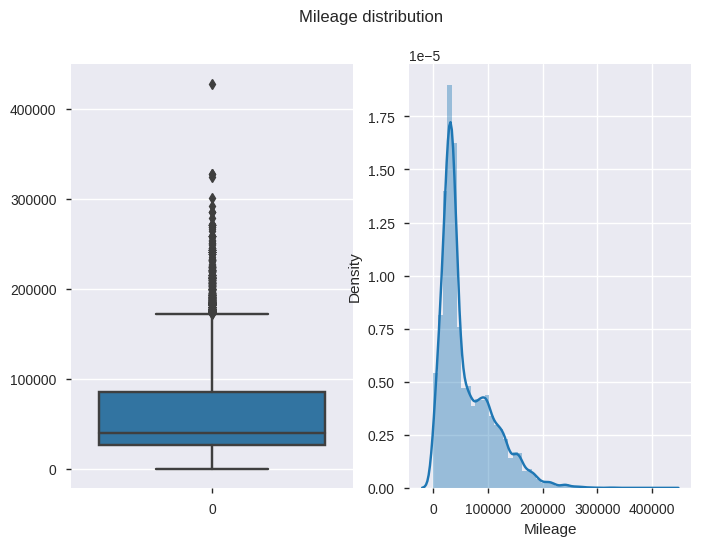

In [161]:
fig, (ax_box, ax_hist) = plt.subplots(1, 2)
fig.suptitle('Mileage distribution')
sns.boxplot(orient='v', data=vehicles_dataset['Mileage'], ax=ax_box)
sns.distplot(vehicles_dataset['Mileage'], ax=ax_hist)

In [144]:
scipy.stats.iqr(vehicles_dataset['Mileage'])/(-np.percentile(vehicles_dataset['Mileage'], 25, interpolation='midpoint') + np.percentile(vehicles_dataset['Mileage'], 50, interpolation='midpoint'))

4.375845102163462

Following into the variables list with the least null values, 'MPG' comes up.

In [ ]:
print(vehicles_dataset['MPG'].value_counts())
vehicles_dataset['MPG'].isnull().sum()

17 cty / 25 hwy      603
29 cty / 37 hwy      592
N/A cty / N/A hwy    543
28 cty / 39 hwy      381
26 cty / 33 hwy      365
                    ... 
129 cty / 102 hwy      1
29 cty / 27 hwy        1
12 cty / 14 hwy        1
14 cty / 24 hwy        1
31 cty / 47 hwy        1
Name: MPG, Length: 271, dtype: int64


18

This column has only 18 null values, however, they are also represented as a True value as 'N/A cty / N/A hwy', as seen down below.
As there are around 500 of these values, they will be categorized as well.

In [ ]:
sorted(list(vehicles_dataset.dropna(subset=['MPG'])['MPG'].unique()))

['10 cty / 16 hwy',
 '10 cty / 17 hwy',
 '101 cty / 93 hwy',
 '102 cty / 105 hwy',
 '104 cty / 91 hwy',
 '106 cty / 92 hwy',
 '11 cty / 15 hwy',
 '11 cty / 16 hwy',
 '11 cty / 17 hwy',
 '11 cty / 18 hwy',
 '11 cty / N/A hwy',
 '12 cty / 14 hwy',
 '12 cty / 16 hwy',
 '12 cty / 17 hwy',
 '12 cty / 18 hwy',
 '12 cty / 19 hwy',
 '120 cty / 112 hwy',
 '121 cty / 103 hwy',
 '122 cty / 108 hwy',
 '122 cty / 93 hwy',
 '124 cty / 94 hwy',
 '126 cty / 101 hwy',
 '126 cty / 105 hwy',
 '126 cty / 99 hwy',
 '129 cty / 102 hwy',
 '13 cty / 16 hwy',
 '13 cty / 17 hwy',
 '13 cty / 18 hwy',
 '13 cty / 19 hwy',
 '13 cty / 20 hwy',
 '13 cty / 21 hwy',
 '13 cty / 22 hwy',
 '137 cty / 111 hwy',
 '14 cty / 17 hwy',
 '14 cty / 18 hwy',
 '14 cty / 19 hwy',
 '14 cty / 20 hwy',
 '14 cty / 21 hwy',
 '14 cty / 22 hwy',
 '14 cty / 23 hwy',
 '14 cty / 24 hwy',
 '15 cty / 17 hwy',
 '15 cty / 18 hwy',
 '15 cty / 19 hwy',
 '15 cty / 20 hwy',
 '15 cty / 21 hwy',
 '15 cty / 22 hwy',
 '15 cty / 23 hwy',
 '15 cty / 24 hwy

In [ ]:
def MPG_categorize(MPG):
    if MPG in ['N/A cty / N/A hwy', np.NaN]:
        return 'Another'
    else:
        cty = int(re.findall('[0-9]+ c', str(MPG))[0][:-2])
        hwy = re.findall('/ [0-9]+', str(MPG))
        if hwy == []:
            return 'Another'
        elif cty >= 60:
            return 'up from 60 cty / up from 50 hwy'
        else:
            hwy = int(hwy[0][2:])
            return str(cty)[0] + "0-" + str(cty)[0] + "9 cty / " + str(hwy)[0] + "0-" + str(hwy)[0] + "9 hwy"

vehicles_dataset['MPG'] = vehicles_dataset['MPG'].apply(MPG_categorize)
vehicles_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              7011
10-19 cty / 20-29 hwy              4193
20-29 cty / 20-29 hwy              1899
30-39 cty / 40-49 hwy               635
Another                             562
30-39 cty / 30-39 hwy               482
10-19 cty / 10-19 hwy               433
40-49 cty / 40-49 hwy               303
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
40-49 cty / 30-39 hwy                45
50-59 cty / 40-49 hwy                41
50-59 cty / 50-59 hwy                 9
30-39 cty / 20-29 hwy                 6
Name: MPG, dtype: int64

30, 40 and 50 cty categories are being gathered so outliers disappear.

In [ ]:
def MPG_categorize2(MPG):
    if MPG in ['30-39 cty / 20-29 hwy', '30-39 cty / 30-39 hwy']:
        return '30-39 cty / 20-39 hwy'
    elif MPG in ['50-59 cty / 40-49 hwy', '50-59 cty / 50-59 hwy']:
        return '50-59 cty / 40-59 hwy'
    elif MPG in ['40-49 cty / 30-39 hwy', '40-49 cty / 40-49 hwy']:
        return '40-49 cty / 30-49 hwy'
    else:
        return MPG
    

vehicles_dataset['MPG'] = vehicles_dataset['MPG'].apply(MPG_categorize2)
vehicles_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              7011
10-19 cty / 20-29 hwy              4193
20-29 cty / 20-29 hwy              1899
30-39 cty / 40-49 hwy               635
Another                             562
30-39 cty / 20-39 hwy               488
10-19 cty / 10-19 hwy               433
40-49 cty / 30-49 hwy               348
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
50-59 cty / 40-59 hwy                50
Name: MPG, dtype: int64

'Transmission' feature presents only two true values, as logically thought. We will just get rid of null values then.

In [ ]:
print(vehicles_dataset['Transmission'].isnull().sum())
vehicles_dataset['Transmission'].value_counts()

13


Automatic    15406
Manual         479
Name: Transmission, dtype: int64

In [ ]:
vehicles_dataset.dropna(subset=['Transmission'], inplace=True)

The places where the vehicles are located are defined by city and state as two variables.

Since 'Location (City)' has a lot of values, as it denotes several specific cities and towns, it will be taken out from the model.

In [ ]:
print(vehicles_dataset['Location (City)'].isnull().sum())
vehicles_dataset['Location (State)'].isnull().sum()

86


122

In [ ]:
vehicles_dataset['Location (State)'].unique()

array(['WA', 'TX', 'CA', 'FL', 'MS', 'VA', 'OH', 'AL', 'IN', 'OK', 'GA',
       'NY', 'MA', 'IL', 'NJ', 'TN', 'NC', 'MO', 'ME', 'OR', 'MD', 'MN',
       'AZ', 'WI', 'SC', nan, 'LA', 'CO', 'KY', 'NM', 'AR', 'PA', 'CT',
       'KS', 'NV', 'ID', 'UT', 'IA', 'HI', 'NH', 'MI', 'MT', 'NE', 'WY',
       'AK', 'DE', 'WV', 'VT', 'SD', 'RI', 'UK', 'ND', 'SO'], dtype=object)

In [ ]:
vehicles_dataset['Location (State)'].unique().shape[0]
vehicles_dataset.dropna(subset=['Location (State)'], inplace=True)
vehicles_dataset.shape

(15763, 18)

'Bed Length' is next to go through.

In [ ]:
print("'Bed Length' column has", vehicles_dataset["Bed Length"].isnull().sum(), "null values.")
print("The other ones (", vehicles_dataset["Bed Length"].notnull().sum(), ") are:", sep="")
vehicles_dataset['Bed Length'].value_counts()

'Bed Length' column has 14542 null values.
The other ones (1221) are:


Short Bed       571
Standard Bed    532
Long Bed        118
Name: Bed Length, dtype: int64

As seen above the bed length is null for almost all cases, so it will be discarded.

In [ ]:
vehicles_dataset.drop(columns='Bed Length', inplace=True)
vehicles_dataset.columns

Index(['Make', 'Model', 'Year', 'Mileage', 'Transmission', 'Engine',
       'Exterior Color', 'Interior Color', 'MPG', 'Fuel Type', 'Drive Type',
       'Location (City)', 'Location (State)', 'Style', 'Condition (Accidents)',
       'Options Level', 'Price'],
      dtype='object')

In [ ]:
cols_by_nulls.pop("Bed Length")

15641

In [ ]:
print("Exterior Color has", cols_by_nulls['Exterior Color'], "null values")
print(vehicles_dataset['Exterior Color'].value_counts().sum(), "not null values and values count:", cars_dataset['Exterior Color'].nunique())
vehicles_dataset['Exterior Color'].value_counts()

Exterior Color has 5840 null values
10617 not null values and values count: 569


Black                 759
Oxford White          421
Summit White          392
Gray                  388
White                 362
                     ... 
Meteor Gray Pearl       1
Light Blue              1
Redondo Red Pearl       1
Green Tea Metallic      1
Sandstone Gray          1
Name: Exterior Color, Length: 569, dtype: int64

In [ ]:
list(vehicles_dataset['Exterior Color'].value_counts().index)

['Black',
 'Oxford White',
 'Summit White',
 'Gray',
 'White',
 'Super White',
 'Crystal Black Pearl',
 'Super Black',
 'Gun Metallic',
 'Silver Ice Metallic',
 'Shadow Black',
 'Glacier White',
 'White Orchid Pearl',
 'Silver',
 'Fresh Powder',
 'Magnetic Metallic',
 'Brilliant Silver',
 'Unknown',
 'Granite Pearlcoat',
 'Polar White',
 'Blue',
 'Magnetic Black',
 'Red',
 'Jet Black',
 'Agate Black',
 'Pearl White',
 'Black Sand Pearl',
 'Quartz White Pearl',
 'Predawn Gray Mica',
 'Phantom Black',
 'Taffeta White',
 'White Diamond Pearl',
 'Ice Silver Metallic',
 'Billet Clearcoat',
 'Clear White',
 'Pure White',
 'Snow White Pearl',
 'Alpine White',
 'Sparkling Silver',
 'Aurora Black',
 'Eminent White Pearl',
 'Symphony Silver',
 'Ebony Black',
 'Scarlet Red',
 'Caspian Blue',
 'Deep Blue Pearl',
 'Dark Gray Metallic',
 'Race Red',
 'Black Obsidian',
 'Gold',
 'Vice White',
 'Blizzard Pearl',
 'Onyx Black',
 'Crystal White Pearl',
 'Magnetic',
 'Brown',
 'Black Clearcoat',
 'Graphi

'Exterior Color' has a lot of unique values, but they can be regrouped given that these values represent almost the same color for each case, by category.

In [ ]:
vehicles_dataset['Exterior Color'].value_counts()

Black                 759
Oxford White          421
Summit White          392
Gray                  388
White                 362
                     ... 
Meteor Gray Pearl       1
Light Blue              1
Redondo Red Pearl       1
Green Tea Metallic      1
Sandstone Gray          1
Name: Exterior Color, Length: 569, dtype: int64

The following function will check whether the passed color names belong to the same category.

In [ ]:
def color_in(color, *argc):
    checks = []
    for arg in argc:
        if arg in str(color).lower():
            checks.append(True)
        else:
            checks.append(False)
    if any(checks):
        return True
    else:
        return False

Now, this function will tell if the conditions are met so that it categorizes the original values to this set-up. 

In [ ]:
def ext_colors_categorize(ext_color):
    if color_in(ext_color, "black") or "Obsidian" == ext_color:
        return "Black"
    elif color_in(ext_color, "white", "glacier") or ext_color in ["Fresh Powder", "Blizzard Pearl", "Starfire Pearl"]:
        return "White"
    elif color_in(ext_color, "green"):
        return "Green"
    elif color_in(ext_color, "blue", "aqua"):
        return "Blue"
    elif color_in(ext_color, "silver", "gray", "magnetic", "pearlcoat", "tungsten", "graphite", "gun", "platinum", "titanium", "billet"):
        return "Silver or Grey"
    elif color_in(ext_color, "red", "cherry", "ruby", "sun", "rosso", "scarlet"):
        return "Red"
    elif color_in(ext_color, "gold"):
        return "Gold"
    elif color_in(ext_color, "brown", "beige"):
        return "Beige or Brown"
    elif color_in(ext_color, "yellow"):
        return "Yellow"
    else:
        return "Unknown"

In [ ]:
vehicles_dataset['Exterior Color'] = vehicles_dataset['Exterior Color'].apply(ext_colors_categorize)

In [ ]:
vehicles_dataset['Exterior Color'].value_counts()

Unknown           5711
White             3269
Black             2617
Silver or Grey    2554
Blue               827
Red                644
Beige or Brown      59
Gold                53
Green               24
Yellow               5
Name: Exterior Color, dtype: int64

Like there are just a few cases where the vehicles are yellow or green, we will get rid of these values.

In [ ]:
colors_to_drop = list(vehicles_dataset['Exterior Color'].value_counts().index[-4:])
colors_to_drop

['Beige or Brown', 'Gold', 'Green', 'Yellow']

In [ ]:
indexes = []


for color in colors_to_drop:
    indexes += list(cars_dataset[cars_dataset["Exterior Color"] == color].index)
    
    
vehicles_dataset.drop(indexes, inplace=True)
vehicles_dataset.shape

(15622, 17)

Text(0.5, 1.0, 'Exterior colors by occurrences')

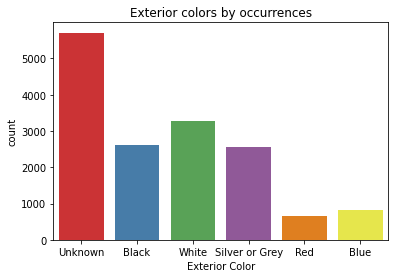

In [ ]:
ax = sns.countplot(x="Exterior Color", data=vehicles_dataset, palette="Set1")
ax.set_title("Exterior colors by occurrences")

Now, 'Engine' will be analyzed.

In [ ]:
vehicles_dataset['Engine'].isnull().sum()

2976

In [ ]:
vehicles_dataset['Engine'].value_counts()

2.5L Inline-4 Gas             1972
2.4L Inline-4 Gas             1354
1.8L Inline-4 Gas             1345
3.6L V-6 Gas                  1319
2.0L Inline-4 Gas             1274
                              ... 
6.6L V-12 Gas Turbocharged       1
3.0L V-6 Hybrid                  1
5.0L V-10 Gas                    1
3.2L Flat-6 Gas                  1
2.9L V-6 Gas Turbocharged        1
Name: Engine, Length: 119, dtype: int64

We are going to check on all the variants for each 'Inline', 'Flat' and 'Vs' engines, so we can filter them into more crowded categories

In [ ]:
sorted(vehicles_dataset['Engine'].value_counts().index.to_list())

['0.6L Inline-2 Plug-In',
 '1.0L Inline-3 Gas',
 '1.2L Inline-3 Gas',
 '1.3L Inline-4 Hybrid',
 '1.4L Inline-4 Gas',
 '1.4L Inline-4 Plug-In',
 '1.5L Inline-4 Gas',
 '1.5L Inline-4 Hybrid',
 '1.5L Inline-4 Plug-In',
 '1.6L Inline-4 Gas',
 '1.6L Inline-4 Hybrid',
 '1.7L Inline-4 Gas',
 '1.8L Inline-4 Gas',
 '1.8L Inline-4 Hybrid',
 '1.8L Inline-4 Plug-In',
 '2.0L Flat-4 Gas',
 '2.0L Inline-4 Gas',
 '2.0L Inline-4 Hybrid',
 '2.0L Inline-4 Plug-In',
 '2.0L V-4 Gas Turbocharged',
 '2.2L Inline-4 Gas',
 '2.3L Inline-4 Gas',
 '2.3L V-4 Gas Turbocharged',
 '2.4L Inline-4 Gas',
 '2.4L Inline-4 Hybrid',
 '2.4L Inline-5 Gas',
 '2.5L Flat-4 Gas',
 '2.5L Flat-6 Gas',
 '2.5L Inline-4 Gas',
 '2.5L Inline-4 Hybrid',
 '2.5L Inline-5 Gas',
 '2.5L Inline-6 Gas',
 '2.5L V-6 Gas',
 '2.7L Flat-6 Gas',
 '2.7L Inline-4 Gas',
 '2.7L V-6 Gas',
 '2.7L V-6 Gas Turbocharged',
 '2.8L V-6 Gas',
 '2.9L Inline-4 Gas',
 '2.9L V-6 Gas Turbocharged',
 '3.0L Flat-6 Gas',
 '3.0L Inline-6 Gas',
 '3.0L V-6 Gas',
 '3.0L V-6 

In [ ]:
for j in ["Inline", "Flat", "V"]:

    for i in vehicles_dataset['Engine'].value_counts().index.to_list():
        if j in i:
            print(i)

2.5L Inline-4 Gas
2.4L Inline-4 Gas
1.8L Inline-4 Gas
2.0L Inline-4 Gas
1.6L Inline-4 Gas
2.0L Inline-4 Hybrid
1.8L Inline-4 Hybrid
3.0L Inline-6 Gas
2.5L Inline-4 Hybrid
1.5L Inline-4 Gas
2.4L Inline-4 Hybrid
0.6L Inline-2 Plug-In
1.5L Inline-4 Hybrid
1.4L Inline-4 Plug-In
2.5L Inline-5 Gas
2.0L Inline-4 Plug-In
3.2L Inline-6 Gas
2.2L Inline-4 Gas
2.7L Inline-4 Gas
1.2L Inline-3 Gas
2.3L Inline-4 Gas
4.2L Inline-6 Gas
1.8L Inline-4 Plug-In
2.5L Inline-6 Gas
4.7L Inline-8 Gas
3.7L Inline-5 Gas
1.3L Inline-4 Hybrid
2.4L Inline-5 Gas
1.5L Inline-4 Plug-In
4.0L Inline-6 Gas
2.9L Inline-4 Gas
1.6L Inline-4 Hybrid
1.4L Inline-4 Gas
1.7L Inline-4 Gas
1.0L Inline-3 Gas
3.5L Inline-5 Gas
2.5L Flat-4 Gas
2.0L Flat-4 Gas
3.8L Flat-6 Gas
3.6L Flat-6 Gas
3.0L Flat-6 Gas
2.5L Flat-6 Gas
2.7L Flat-6 Gas
3.4L Flat-6 Gas
3.2L Flat-6 Gas
3.6L V-6 Gas
3.5L V-6 Gas
5.3L V-8 Gas
5.7L V-8 Gas
4.0L V-6 Gas
3.5L V-6 Gas Turbocharged
5.0L V-8 Gas
6.0L V-8 Gas
3.7L V-6 Gas
6.2L V-8 Gas
3.8L V-6 Gas
3.0L V-6 Ga

In [ ]:
def engine_categorize(engine_type):
    if "V-" in engine_type:
        return re.findall("V.+", engine_type)[0]
    elif "Inline" in engine_type:
        return re.findall("I.+", engine_type)[0]
    elif "Flat" in engine_type:
        return re.findall("F.+", engine_type)[0]
    else:
        return "Another"

In [ ]:
re.findall("V-[1-8][0-2]?", "5.4L V-10 Gas Supercharged")

['V-10']

In [ ]:
vehicles_dataset['Engine'] = cars_dataset['Engine'].astype(str)
vehicles_dataset['Engine'].apply(engine_categorize).value_counts()

Inline-4 Gas             6416
V-6 Gas                  3279
Another                  3051
V-8 Gas                  1362
Inline-4 Hybrid           441
V-6 Gas Turbocharged      362
Flat-4 Gas                235
Inline-6 Gas              106
V-4 Gas Turbocharged       61
Inline-4 Plug-In           49
V-8 Gas Turbocharged       45
Flat-6 Gas                 40
V-6 Gas Supercharged       36
Inline-5 Gas               31
Inline-2 Plug-In           25
V-8 Gas Supercharged       16
V-6 Hybrid                 15
V-12 Gas                   12
Inline-3 Gas               12
V-10 Gas                   10
V-12 Gas Turbocharged       7
Inline-8 Gas                6
V-6 Plug-In                 3
V-8 Hybrid                  2
Name: Engine, dtype: int64

Let's filter these engine types up a bit more, so outliers stay out.

In [ ]:
def engine_categorize(engine_type):
    if engine_type.endswith("V-6 Gas"):
        return re.findall("V.+", engine_type)[0]
    elif "V-6" in engine_type:
        return "V-6 Gas Turbo/Supercharged"
    elif "V-8" in engine_type:
        return "V-8"
    elif "V-" in engine_type:
        return "V-4/10/12"
    elif "Inline-4 Gas" in engine_type:
        return "Inline-4 Gas"
    elif "Inline-4" in engine_type:
        return "Inline-4 Plug-In/Hybrid"
    elif "Inline-6" in engine_type:
        return "Inline-6"
    elif "Inline" in engine_type:
        return "Inline 2/3/5/8"
    elif "Flat" in engine_type:
        return re.findall("Flat-[46]", engine_type)[0]
    else:
        return "Another"

In [ ]:
vehicles_dataset['Engine'] = cars_dataset['Engine'].apply(engine_categorize)
vehicles_dataset['Engine'].value_counts()

Inline-4 Gas                  6416
V-6 Gas                       3279
Another                       3051
V-8                           1425
Inline-4 Plug-In/Hybrid        490
V-6 Gas Turbo/Supercharged     416
Flat-4                         235
Inline-6                       106
V-4/10/12                       90
Inline 2/3/5/8                  74
Flat-6                          40
Name: Engine, dtype: int64